In [184]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow_hub as hub

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate

In [185]:
train_limpio = pd.read_csv("train_limpio_con_stemming.csv",encoding = "ISO-8859-1")
train_limpio.head(1)

,text,target,cantidad_links,cantidad_signos_pregunta,repeticiones,longitud_tweet,letras_seguidas,sentimiento,objetividad,the,...,he is,insultos_por_tweet,expresiones_por_tweet,bombing,suicide,accident,disaster,police,died,years
0,our deed are the reason of this earthquak may ...,1,0,0,1,70,2,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0


In [186]:
target = train_limpio["target"]
target.head(2)

0    1
1    1
Name: target, dtype: int64

In [187]:
VALIDATION_SIZE = .8
TEST_SIZE = .9
WANTED_COLUMNS = ["text", "cantidad_links", "cantidad_signos_pregunta", "repeticiones", "longitud_tweet", "letras_seguidas", "sentimiento", "insultos_por_tweet", "expresiones_por_tweet", "target", "objetividad"]
df = train_limpio[WANTED_COLUMNS]
raw_train_df, raw_val_df, raw_test_df = np.split(df.sample(frac=1), [int(VALIDATION_SIZE*len(df)), int(TEST_SIZE*len(df))])

In [188]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

## Sily inputs for text

In [189]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((raw_train_df["text"].to_numpy(dtype="str"), raw_train_df["target"].values))
raw_val_ds = tf.data.Dataset.from_tensor_slices((raw_val_df["text"].to_numpy(dtype="str"), raw_val_df["target"].values))
raw_test_ds = tf.data.Dataset.from_tensor_slices((raw_test_df["text"].to_numpy(dtype="str"), raw_test_df["target"].values))


train_examples_batch, train_labels_batch = next(iter(raw_train_ds.batch(10)))

In [190]:
raw_train_ds

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [191]:
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'astro stun poor defens it not all on the pitcher if our bat are mia like the top of  inning this team is in troubl',
       b'lao flood  villag underwat world vision respond ',
       b'sad befor she could save human ursula drown in the drool of a protoshoggoth but at least she sort of die do what she love',
       b'i realli want a rolo blizzard but mom said no so i guess no dq tonight',
       b'check out ameribag healthi back bag shoulder cross bodi backpack khaki tan beig nylon  ebay',
       b'apc chieftain task dickson on  flood donat to bayelsa ',
       b'school in western uganda still burn down build dure strikesstrik in western uganda alway lit liter',
       b'raynbowaffair editor in chief diamondkesawn releas issu   of ramag fashion model and mayhem',
       b' shut up freshman it past ur curfew u need some sleep u spend too much of ur time watch tv instead of go outsid ',
       b' head it hit the wall behind him with 

In [192]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 1, 0, 0, 1, 1, 0, 0, 1])>

In [193]:
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 0.1076659 , -0.74896127,  0.59055007, -0.7523434 , -1.2469462 ,
        -0.69484806, -0.34146762, -0.440869  , -0.42524195,  0.04975181,
        -0.49125284,  0.79167527,  0.2864506 ,  0.18599412, -1.448118  ,
         1.0972437 ,  2.0727658 , -0.4849483 , -1.6095817 , -0.11631514],
       [ 0.6265027 ,  0.06931552,  1.6541213 ,  0.04014789,  0.41452822,
        -0.6037382 ,  0.12138324,  0.5467771 , -0.30655074, -0.6401909 ,
         0.41591954, -0.01140678, -0.2837213 ,  0.00338283, -0.5705617 ,
         0.6479602 ,  0.7321466 ,  0.02429441, -0.2589731 , -0.39861873],
       [ 0.923477  , -1.1803849 ,  1.3244759 , -0.29385617, -1.4029105 ,
        -2.6147838 , -1.1153462 ,  1.4884878 ,  2.2629213 ,  0.24818201,
        -1.0025564 ,  0.30414402,  0.23995204,  0.2580976 , -2.4595478 ,
         0.9209849 ,  1.6217976 , -1.4231983 , -1.4096842 , -0.5555772 ]],
      dtype=float32)>

### Esto es el modelo facil

In [194]:
def getModel(epochs):
    model1 = tf.keras.Sequential()
    model1.add(hub_layer)
    model1.add(tf.keras.layers.Dense(16, activation='relu'))
    model1.add(tf.keras.layers.Dense(1))
    model1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', 'binary_crossentropy'])
    keras.utils.plot_model(model1, "my_first_model.png", show_shapes=True)
    return model1.fit(raw_train_ds.shuffle(5000).batch(512),
                    epochs=epochs,
                    validation_data=raw_val_ds.batch(512), verbose=0), model1
history50Epochs, model1 = getModel(50)

dict_keys(['loss', 'accuracy', 'binary_crossentropy', 'val_loss', 'val_accuracy', 'val_binary_crossentropy'])


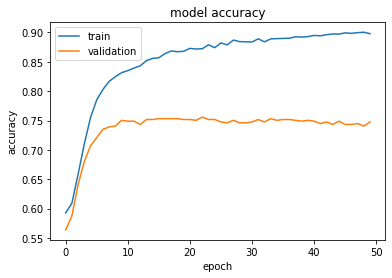

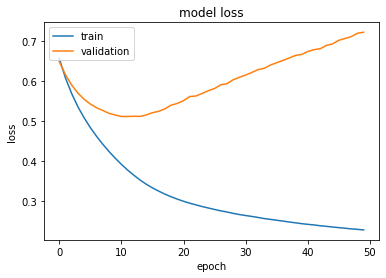

In [195]:
def printHistory(history):
    print(history.history.keys())
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
printHistory(history50Epoch)

In [196]:
model1.evaluate(raw_test_ds.batch(512))

2/2 [==============================] - 0s 2ms/step - loss: 0.5384 - accuracy: 0.7605 - binary_crossentropy: 2.8780


[0.5383551120758057, 0.7605041861534119, 2.8780035972595215]

# El accuracy en validation se estanca en epoch 20 +/-

dict_keys(['loss', 'accuracy', 'binary_crossentropy', 'val_loss', 'val_accuracy', 'val_binary_crossentropy'])


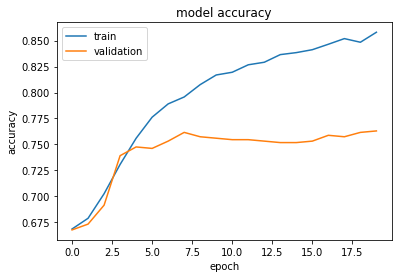

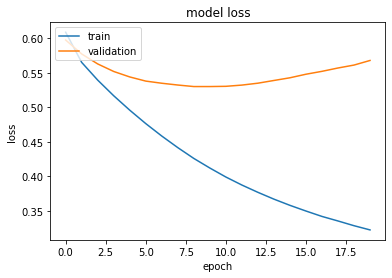

In [205]:
history20Epochs, model1 = getModel(20)
printHistory(history20Epochs)

In [206]:
model1.evaluate(raw_test_ds.batch(512))

2/2 [==============================] - 0s 2ms/step - loss: 0.5066 - accuracy: 0.7759 - binary_crossentropy: 2.6070


[0.5066360831260681, 0.7759103775024414, 2.6070475578308105]

## Submission

In [199]:
test_limpio = pd.read_csv("test_limpio_con_stemming.csv",encoding = "ISO-8859-1")
test_limpio.head(2)

,id,keyword,location,text,cantidad_links,cantidad_signos_pregunta,repeticiones,longitud_tweet,letras_seguidas,sentimiento,...,he is,insultos_por_tweet,expresiones_por_tweet,bombing,suicide,accident,disaster,police,died,years
0,0,NaN,NaN,just happen a terribl car crash,0,0,1,40,2,-1.00,...,0,0,0,0,0,0,0,0,0,0
1,2,NaN,NaN,heard about earthquak is differ citi stay safe...,0,0,1,70,2,0.25,...,0,0,0,0,0,0,0,0,0,0


In [200]:
predictionsInputsDF = test_limpio["text"]

In [201]:
predictionsInputsX = tf.data.Dataset.from_tensor_slices((predictionsInputsDF.to_numpy(dtype="str")))

In [202]:
predictionsOutput = model1.predict_classes(predictionsInputsX.batch(512))

In [203]:
test_limpio["target"] = predictionsOutput
test_limpio[["id", "target"]].head(10)

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [204]:
test_limpio[["id", "target"]].to_csv('NN_predictions.csv', index=False)